In [114]:
import json
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib
from climdist.utils import load_df
import seaborn as sns
import umap
from top2vec import Top2Vec
import colorcet as cc
import re
from itertools import chain
import time

In [2]:
df = load_df('main')

In [3]:
ruler = pd.read_excel('../pipeline/ruler_patterns_060522.xlsx')

In [4]:
t2v = Top2Vec.load('../data/models/top2vec_150522/t2v_model.pkl')

In [217]:
def plot_umap(model, reduction, exceptions=[], topic_labels=None):
    
    t2v.hierarchical_topic_reduction(reduction)
    reduced = True
    
    relevant_ids = [doc_id for doc_id, top in
                    zip(t2v.document_ids, t2v.get_documents_topics(t2v.document_ids, reduced=True)[0])
                    if top not in exceptions]
    relevant_vectors = [vec for vec, top in
                        zip(t2v.document_vectors, t2v.get_documents_topics(t2v.document_ids, reduced=True)[0])
                        if top not in exceptions]
    
    topic_vector_df = pd.DataFrame(index=relevant_ids, columns=range(1,301),
                                   data=relevant_vectors)
    
    reducer = umap.UMAP()
    umapped = reducer.fit_transform(topic_vector_df)
    
    umap_df = pd.DataFrame(umapped, columns=['x', 'y'])
    main_topics = t2v.get_documents_topics(relevant_ids, reduced=True)[0]
    umap_df['topic'] = main_topics
    
    plt.figure(figsize=(12,12))
    sns.scatterplot(data=umap_df, x='x', y='y', s=3, hue='topic',
            palette=sns.color_palette(cc.glasbey, n_colors=len(umap_df.topic.unique())))
    plt.legend(ncol=2)
    plt.grid(False)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.gca().yaxis.set_ticklabels([])
    plt.gca().xaxis.set_ticklabels([])
    plt.show()
    

def compare_reduced_topics(model, reduction, exceptions=[], stackplot=False):
    
    plot_umap(model, reduction, exceptions)
    
    if stackplot:
        topic_df = map_topics_to_main_df(t2v, df, reduced=True)
        topics_stackplot(topic_df, df, relative='global', timerange=range(1802,1889))
        plt.show()

    print(f'\n\n\n\n\nReduction to {reduction} topics\n')
    if reduction < t2v.get_num_topics():
        t2v.hierarchical_topic_reduction(reduction)
        reduced = True
    else:
        reduced = False
    words, scores, nums = t2v.get_topics(reduced=reduced)
    for num, wordlist in zip(nums, words):
        if num not in exceptions:
            print(f'\n---------- Topic {num} from {reduction} ----------')
            print(wordlist)
            
            
def map_topics_to_main_df(t2v, df, reduction):
    
    t2v.hierarchical_topic_reduction(reduction)
    
    document_ids = [int(doc_id.split('_')[0]) for doc_id in t2v.document_ids] # first part of doc_id -> rows
    span_ids = [doc_id.split('_')[1] for doc_id in t2v.document_ids] # second part of doc_id -> columns
    main_topics = t2v.get_documents_topics(t2v.document_ids, reduced=True)[0] # main topic of each span -> cells
    
    df_melt = pd.DataFrame(zip(document_ids, span_ids, main_topics),
                           columns=['doc_id', 'span_id', 'main_topic']).convert_dtypes()
    
    df_melt = pd.melt(df_melt, id_vars=['doc_id', 'span_id'], value_vars='main_topic')[['doc_id', 'span_id', 'value']]
    df_melt.columns = ['doc_id', 'span_id', 'main_topic']
    df_melt.set_index('doc_id', inplace=True)
    df_melt.index.name = None
    
    df_topics = df.loc[df_melt.index]
    df_topics = pd.concat([df_topics, df_melt], axis=1)
    #df_topics.loc[['span_id', 'main_topic']] = df_melt.loc[['span_id', 'main_topic']]
    
    return df_topics


def topic_example(topic, timerange=range(1802, 1889), doc_id=None):
    
    topic_words = t2v.get_topics(reduced=True)[0][topic]
    
    if doc_id:
        sample_text = df_topics.loc[int(doc_id), 'full_text']
        print(type(sample_text))
        print(sample_text)
        print(df_topics.loc[int(doc_id), 'date'])
    else:
        sample = df_topics[df_topics.main_topic == topic].sample()
        sample_text = sample['full_text'].values[0]
        print(sample.date.values[0])
        
    print('\n')
    print(' '.join(['----------'+word+'----------' if word.lower() in topic_words or word.lower() in ruler.key.values
                    else word for word in re.split(r'[,. ]', sample_text)]))
    
    
def get_keywords_for_topics(model):

    with open('../data/processed/all_keywords_100522.json', 'r', encoding='utf8') as f:
        keywords = json.load(f)
        
    wordform_dict = dict(zip(ruler.key, ruler.wordform))
    
    for entry in tqdm(keywords):
        if entry['id'] in df_topics.index:
            entry_topics = df_topics.loc[entry['id'], 'main_topic']
            if type(entry_topics) == int:
                entry['topics'] = [entry_topics]
            else:
                entry['topics'] = list(entry_topics)
        else:
            entry['topics'] = []
            
    topic_kws = {}
    
    for top in tqdm(t2v.get_topics(reduced=True)[2]):
        topic_kws[top] = [wordform_dict[kw[0]] for kw
                          in list(chain.from_iterable([entry['ents']
                          for entry in keywords if top in entry['topics']]))]

    return topic_kws


def get_most_representative_doc(topic, num_docs):
    vec = t2v.topic_vectors_reduced[topic]
    most_similar_doc = t2v.search_documents_by_vector(vec, num_docs)[2][0]
    print(df_topics.loc[int(most_similar_doc.split('_')[0]), 'full_text'])


def topic_stats(topic, num_docs=1):
    
    t2v.generate_topic_wordcloud(topic, background_color='white', reduced=True)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,3))
    
    df_topics.year[df_topics.main_topic == topic].hist(bins=87, ax=ax1)  
    pd.Series(topic_kws[topic]).value_counts()[:10].plot.bar(ax=ax2)
    df_topics.heading2[df_topics.main_topic == topic].value_counts()[:10].plot.bar(ax=ax3)
    
    plt.show()
    
    #vec = t2v.topic_vectors_reduced[topic]
    #most_similar_doc = t2v.search_documents_by_vector(vec, num_docs)[2][0]
    #print(df_topics.loc[int(most_similar_doc.split('_')[0]), 'full_text'])
    
    #for ix in get_most_representative_docs(topic, num_docs=num_docs):
    #    topic_example(topic, doc_id=int(ix))



In [14]:
df_topics = map_topics_to_main_df(t2v, df, 16)

In [19]:
topic_kws = get_keywords_for_topics(t2v)

  0%|          | 0/256996 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

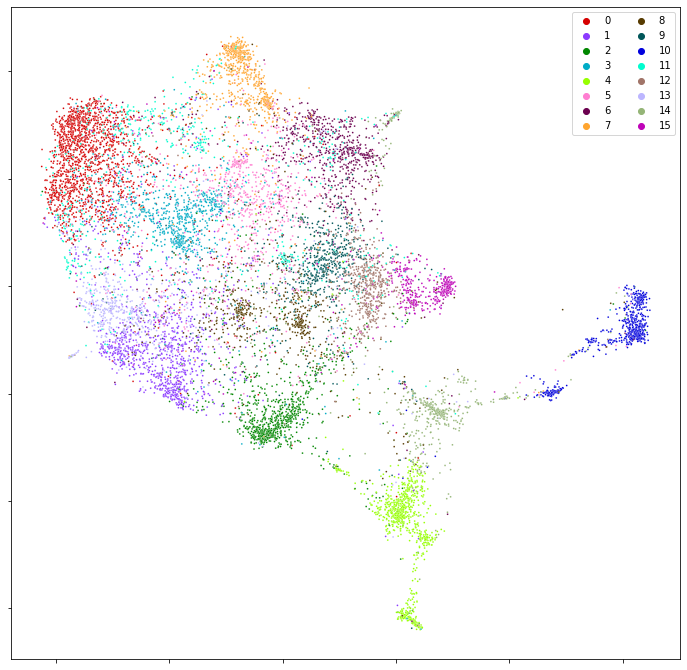

In [119]:
plot_umap(t2v, reduction=16)

In [229]:
topic_names = {0: 'litterature',
               1: 'economie-vegetation',
               2: 'recolte',
               3: 'féstivités',
               4: 'commerce',
               5: 'politique',
               6: 'navigation',
               7: 'krieg',
               8: 'hiver',
               9: 'inondation',
               10: 'telegrammes',
               11: '???',
               12: 'grêle',
               13: 'observations',
               14: 'wasserstande???',
               15: 'foudre'}
               
               

In [ ]:
df_topics.loc[doc_id, 'full_text']

In [227]:
topic_stats(16, num_docs=3)

ValueError: Invalid topic number: valid reduced topics numbers are 0 to 15.

In [224]:
get_most_representative_doc(15, 1)

Inland.

	Die Landwirthschaft und da» Eisenbahn» t a r i f w e s e n.
Jeder, der nicht dem Geschäft», unb praktischen Leben näher steht, kann fich, schreibt «an bet ruf fischen .Pet. Ztg.-, au» dem Schwarzerdgebiet kaum einen Begriff vou der außerordentlichen Wichtigkeit de» Eisenbahntarifwesen« für die Land, wirthschaft und den damit eng verbundenen Getreide-Handel machen. In letzter Zeit, wo bei der Abfertigung der Waare jeder Kopeken mehr oder weniger per Pud streng berechnet und erwägt werden muß, ist die Bedeutung der Eisenbahntarife derart gestiegen, baß c» vorkommt, daß von diesem oder jenem Tarifsätze Leben oder Tod eine» ganzen Rayon» abhängen kann. Uud dennoch werden auf diesem Gebiete so viele Klagen, Unzufriedenheit, Gesuche und Bittschriften in Rußland hervorgerufen, wie auf keinem anderen. E» giebt wohl kaum eine Gouvernement«, oder Kreiefemflwo, eine Stadt oder felbst eine vereinzelt dastehende Eisenbahnstation, von wo au» nicht an die Kanzleien der competenten oder nich

In [226]:
topic_example(15)

1859-06-25


Inlandische Nachrichten 

	Allerhöchstes Manifest 
Von Gottes Gnaden
Wir Alexander der Zweite 
Kaiser und Selbstherrscher aller Reussen
j fa-iu U  s  w  11  %H#&gt;\ nil s  w  К ЩМ!
Indem Wir allen Unsern getreuen Unterthanen kund thun  daß Unsere geliebteste Tante  Ihre Kaiserliche Hoheit  die Großfürstin Maria Pawlowna  ver- j wittwete Großherzogin von Sachsen-Weinar  nach dem Willen j des allmächtigen ®оШё im vierundstebenzigften lahreJhres   Lebens  am 11  Juni dieses Jahres  nach kurzer Krankheit j von diesem Erdenleben in das ewige hinübergegangen ist ! — sind W i r überzeugt  daß alle die lebbasteste Theilnahme j an dem Schmerze nehmen  der Unser Kaiserhaus betroffen ! hat  und daß ste ihre innigen Gebete mit den Unsrigen ver- i einigen werden  sür die Ruhe Ihrer milden und tugendhaft I ten Seele im Reiche der Gerechtigkeit 
Gegeben Zarskoje-Selo am 12  Jnni im eintausend acht- j hundert uennundsunfzigsten Jahre nach Christi Geburt  Unserer Regierung im fünften 
Das

### Notes

topic 5 is probably due to the omnipresence of political news

topic 42 inside topic 9 is about France

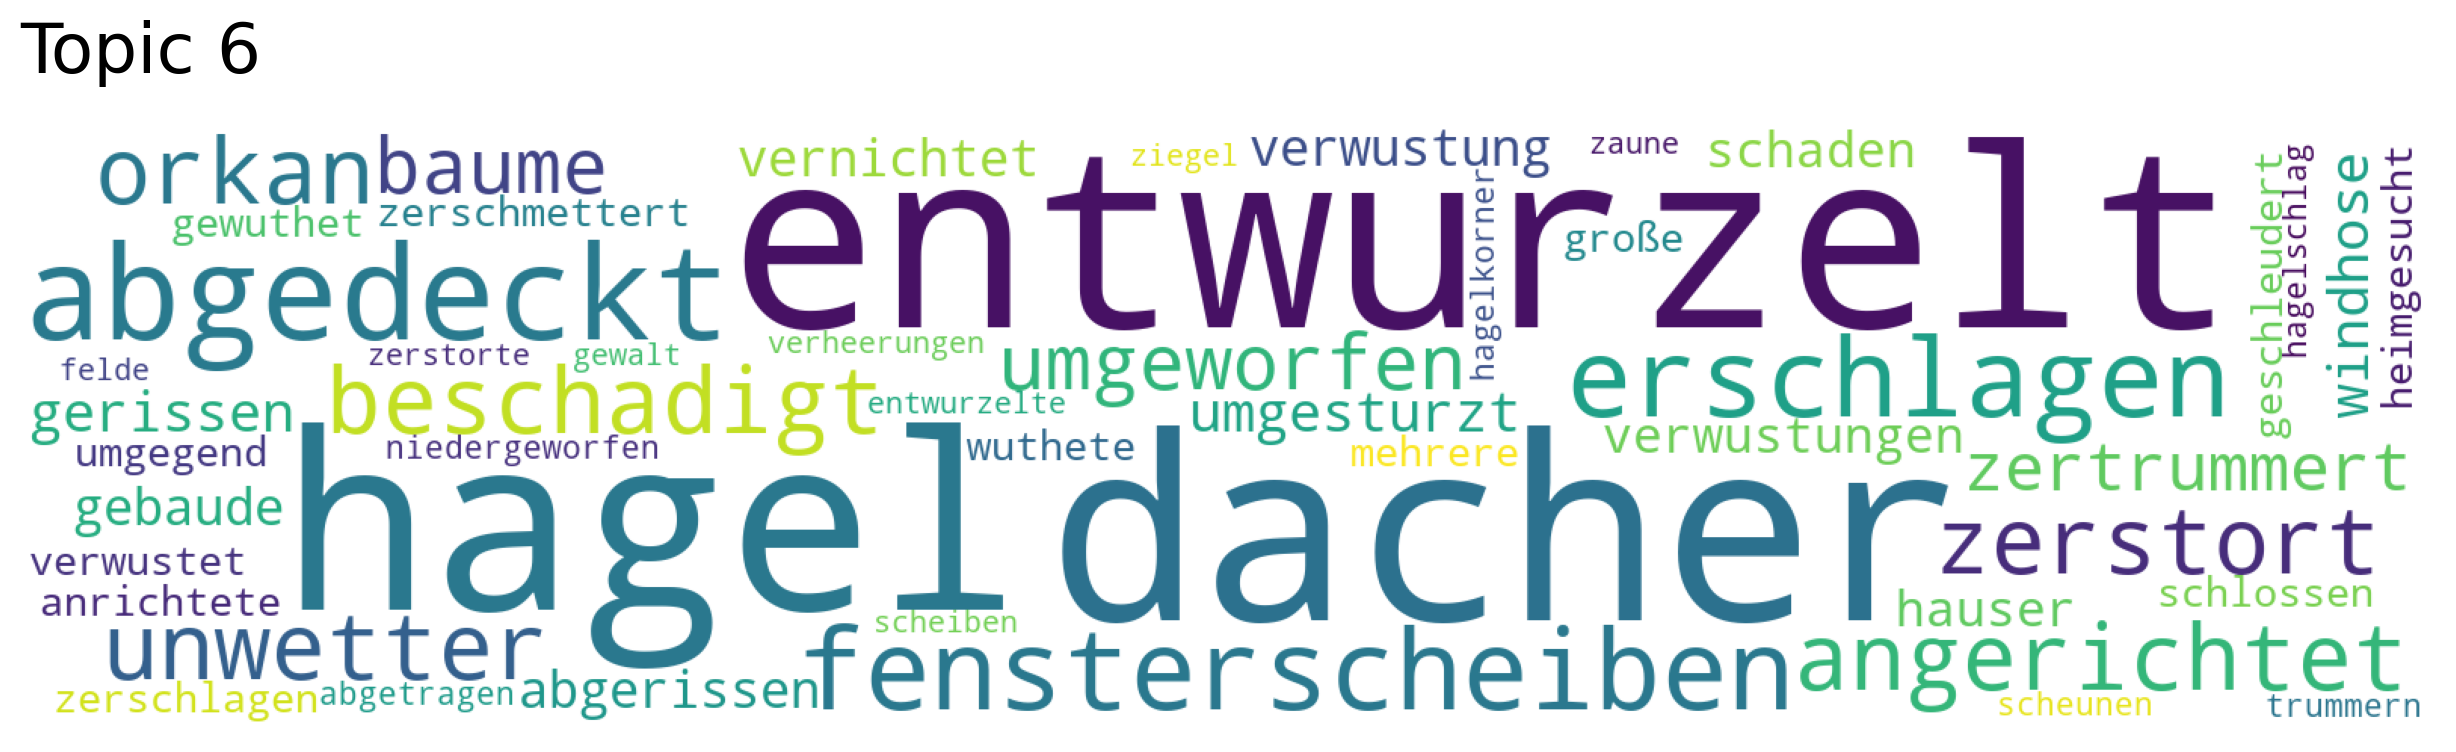

In [211]:
for top in t2v.get_topic_hierarchy()[12]:
    t2v.generate_topic_wordcloud(top, background_color='white')

In [293]:
test_df = df_topics.groupby(['main_topic', 'heading2'])['heading2'].count().to_frame()

In [294]:
test_df

heading2
main_topic heading2                                                    
0          "Dreißig Jahre Paris" von Alphouse Daudet                  1
           # Aus Schauten wird uns geschrieben: Nachfolgender         1
           (18. Fortsetzung.)                                         1
           (19. Fortsetzung.)                                         3
           (2. Fortsetzung.)                                          1
...                                                                 ...
15         — Während i» Salizien in rascher Aufeinander, folg         1
           — Würzburg, l. Juni. Innerhalb weniger Jahre und e         1
           — Zum Besten d er nothleidenden Christen auf der B         1
           — Щ с lo i 11 с r.) Ein Blitz schlug gegen 7 Uhr M         1
           ■Ща, 22; August. Von der Direction der Riga-Mitave         1

[5409 rows x 1 columns]

In [299]:
heading_counts = df.heading2.value_counts()

In [301]:
test_df['heading2'].apply(lambda x: x/heading_counts[x])[:20]

main_topic  heading2                                          
0           "Dreißig Jahre Paris" von Alphouse Daudet             0.000154
            # Aus Schauten wird uns geschrieben: Nachfolgender    0.000154
            (18. Fortsetzung.)                                    0.000154
            (19. Fortsetzung.)                                    0.000484
            (2. Fortsetzung.)                                     0.000154
            (37. Fortsetzung.)                                    0.000154
            (40. Fortsetzung.)                                    0.000484
            (41. Fortsetzung.)                                    0.000154
            (44. Fortsetzung.)                                    0.000154
            (47. Fortsetzung.)                                    0.000154
            (5. Fortsetzung.)                                     0.000318
            (57. Fortsetzung.)                                    0.000318
            (Deutsch von A. Grün. — A

['kiew_odessa' 'moskau_kasan' 'grad_archangel' 'morqens' 'uleaborg_mill'
 'petersburg' 'schwarzen_meere' 'uleaborg' 'barometrisches' 'schwacher'
 'wilna' 'weht' 'windau_wilna' 'barometrische' 'minimum' 'belgien'
 'morgens_maßiger' 'luftdruckes' 'heiterer_himmel' 'kuopio' 'außert'
 'rußland' 'kill' 'domesnees' 'telegramm' 'archangel' 'varometer'
 'maßiger' 'unbestandig' 'luftdruck' 'physikatischen' 'schwarze_meer'
 'saratow' 'charkow' 'centralrußland' 'meteoro' 'rußlands' 'riga'
 'phyfikalischen' 'phyfi' 'sudwestwind' 'baltische' 'physika'
 'thermomecer' 'sudwind' 'ssaratow' 'nordostwind' 'skandinavien'
 'baltischen' 'astrachan']


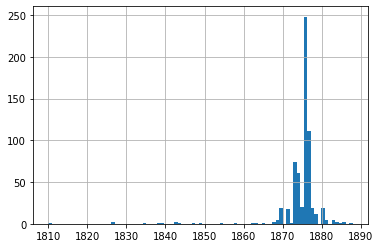

Telegramme                                            491
Telegraphische Witterungsberichte                      47
Nichtofficielle Telegramme                             32
Telegr. der Rig. Telegraphen-Agentur                   10
Neueste Nachrichten                                     9
Berlin                                                  8
Inland                                                  7
Riga                                                    6
Inländische Nachrichten                                 2
Domesnees                                               1
Domesttees                                              1
Snee                                                    1
Libau                                                   1
Februar                                                 1
Riga, 1«. Juli                                          1
Moskau                                                  1
Vom schwedischen Hofe                                   1
-г. SP er пи и

In [280]:
topic_stats(10)

In [152]:
topic_names = {1: 'klima/vegetation',
               2: 'ernte',
               3: ''}

In [154]:
df_topics = map_topics_to_main_df(t2v, df, 16)

In [134]:
#df_topics = map_topics_to_main_df(t2v, df, 16)

In [112]:
main_topics = t2v.get_documents_topics(t2v.document_ids, reduced=True)[0]

In [115]:
pd.Series(main_topics).value_counts().sum()

12291

In [18]:
document_ids = [int(doc_id.split('_')[0]) for doc_id in t2v.document_ids] # first part of doc_id -> rows
span_ids = [int(doc_id.split('_')[1]) for doc_id in t2v.document_ids] # second part of doc_id -> columns
main_topics = t2v.get_documents_topics(t2v.document_ids, reduced=True)[0] # main topic of each span -> cells
possible_spans_in_doc = sorted(set(span_ids))

In [63]:
len(span_ids)

12291

In [125]:
test_df = pd.DataFrame(zip(document_ids, span_ids, main_topics), columns=['doc_id', 'span_id', 'main_topic']).convert_dtypes()

In [126]:
test_df

,doc_id,span_id,main_topic
0,38,0,13
1,132,0,12
2,427,0,2
3,544,0,3
4,550,0,7
...,...,...,...
12286,289638,1,0
12287,289649,0,12
12288,289655,0,1
12289,289695,0,2


In [133]:
df_melt = pd.melt(test_df, id_vars=['doc_id', 'span_id'], value_vars='main_topic')[['doc_id', 'span_id', 'value']]
df_melt.columns = ['doc_id', 'span_id', 'main_topic']
df_melt.set_index('doc_id', inplace=True)

KeyError: 551

,span_id,variable,value
38,0,main_topic,13
132,0,main_topic,12
427,0,main_topic,2
544,0,main_topic,3
550,0,main_topic,7
561,0,main_topic,7
698,0,main_topic,13
707,0,main_topic,17
717,0,main_topic,13
720,0,main_topic,8


In [111]:
pd.melt(test_df, id_vars=['span_id'], value_vars=['span_id', 'main_topic'])[:20]

,span_id,variable,value
0,0,main_topic,13
1,0,main_topic,12
2,0,main_topic,2
3,0,main_topic,3
4,0,main_topic,7
5,0,main_topic,7
6,0,main_topic,13
7,0,main_topic,17
8,0,main_topic,13
9,0,main_topic,8


In [23]:
test_df.groupby(test_df.index)['span_id']

In [140]:
from itertools import islice
print(list(islice(zip(t2v.document_ids, span_ids, main_topics), 20)))

[('38_0', '0', 15), ('132_0', '0', 3), ('427_0', '0', 2), ('544_0', '0', 3), ('550_0', '0', 11), ('561_0', '0', 11), ('698_0', '0', 15), ('707_0', '0', 1), ('717_0', '0', 15), ('720_0', '0', 9), ('748_0', '0', 15), ('800_0', '0', 6), ('800_1', '1', 1), ('1058_0', '0', 11), ('1126_0', '0', 5), ('1568_0', '0', 11), ('1715_0', '0', 11), ('1721_0', '0', 11), ('1759_0', '0', 13), ('1780_0', '0', 6)]


In [ ]:
df_topics = df.loc[document_ids].copy()
    
for span_col in possible_spans_in_doc:
    df_topics.loc[:, 'span_'+span_col] = [top if span_id == span_col else pd.NA for top, span_id in zip(main_topics, span_ids)]

[38,
 132,
 427,
 544,
 550,
 561,
 698,
 707,
 717,
 720,
 748,
 800,
 1058,
 1126,
 1568,
 1715,
 1721,
 1759,
 1780,
 1842,
 1890,
 1935,
 1965,
 2000,
 2063,
 2081,
 2102,
 2137,
 2143,
 2154,
 2171,
 2182,
 2188,
 2247,
 2335,
 2787,
 2828,
 2855,
 2865,
 2878,
 2882,
 2918,
 2923,
 3019,
 3057,
 3061,
 3147,
 3244,
 3272,
 3305,
 3320,
 3327,
 3404,
 3429,
 3511,
 3852,
 3869,
 3875,
 4093,
 4521,
 4569,
 4818,
 4989,
 5046,
 5095,
 5140,
 5369,
 5449,
 5883,
 5890,
 5892,
 6567,
 6685,
 7132,
 7166,
 7215,
 7229,
 7281,
 7310,
 7348,
 7388,
 7391,
 7475,
 7515,
 7788,
 7885,
 7923,
 7966,
 7978,
 8052,
 8076,
 8111,
 8348,
 8444,
 8484,
 8489,
 8616,
 8814,
 8868,
 8912,
 9047,
 9087,
 9395,
 9591,
 9966,
 10041,
 10044,
 10083,
 10111,
 10112,
 10113,
 10114,
 10477,
 10519,
 10521,
 10540,
 10559,
 10560,
 10561,
 10567,
 10573,
 10574,
 10576,
 10619,
 10620,
 10632,
 10647,
 10676,
 10825,
 10862,
 10885,
 10888,
 10899,
 10932,
 10955,
 11049,
 11199,
 11209,
 11356,
 11394

In [126]:
len(document_ids)

12291

In [121]:
t2v.document_ids[:20]

array(['38_0', '132_0', '427_0', '544_0', '550_0', '561_0', '698_0',
       '707_0', '717_0', '720_0', '748_0', '800_0', '800_1', '1058_0',
       '1126_0', '1568_0', '1715_0', '1721_0', '1759_0', '1780_0'],
      dtype='<U8')

In [127]:
len([top if span_id == '0' else pd.NA for top, span_id in zip(main_topics, span_ids)])

12291

In [128]:
df_topics[:20]

,date,year,month,day,pub,heading,full_text,href,text_len,placename,origin_date,origin_month,heading2,readability,span_0,span_1,span_2,span_3,span_4,span_5
38,1802-01-11,1802,1,11,Rigasche Zeitung,DaS Haus Johannes Obwerers sel. Söhae hat auf ...,DaS Haus Johannes Obwerers sel. Söhae hat auf ...,https://proc.dom.lndb.lv/file.axd?id=15117381&...,672,None,None,None,DaS Haus Johannes Obwerers sel. Söhae hat auf ...,1,15,<NA>,<NA>,<NA>,<NA>,<NA>
132,1802-02-15,1802,2,15,Rigasche Zeitung,Vermischte Nachrichten.,Vermischte Nachrichten.\n\n\tEs treibt sich se...,https://proc.dom.lndb.lv/file.axd?id=2102236&a...,7854,None,None,None,Vermischte Nachrichten,1,3,<NA>,<NA>,<NA>,<NA>,<NA>
427,1802-05-28,1802,5,28,Rigasche Zeitung,"Augsburg, den 16ten Mai.","Augsburg, den 16ten Mai.\n\n\tNach einem 4 Woc...",https://proc.dom.lndb.lv/file.axd?id=11907556&...,1319,Augsburg,16,Mai,Augsburg,1,2,<NA>,<NA>,<NA>,<NA>,<NA>
544,1802-07-09,1802,7,9,Rigasche Zeitung,"Berlin, den 29. Junii.","Berlin, den 29. Junii.\n\n\tAm vorigen Sonntag...",https://proc.dom.lndb.lv/file.axd?id=15104407&...,954,Berlin,29,Jun,Berlin,1,3,<NA>,<NA>,<NA>,<NA>,<NA>
550,1802-07-09,1802,7,9,Rigasche Zeitung,"London, den 2. Julii.","London, den 2. Julii.\n\n\tAm 28. lunii ist di...",https://proc.dom.lndb.lv/file.axd?id=15104415&...,1488,London,2,Jul,London,1,11,<NA>,<NA>,<NA>,<NA>,<NA>
561,1802-07-12,1802,7,12,Rigasche Zeitung,"London, den 2. Julii.","London, den 2. Julii.\n\n\tDie He ren Garnerin...",https://proc.dom.lndb.lv/file.axd?id=7539538&a...,2581,London,2,Jul,London,1,11,<NA>,<NA>,<NA>,<NA>,<NA>
698,1802-08-23,1802,8,23,Rigasche Zeitung,"Paris, den 11. August.","Paris, den 11. August.\n\n\tFolgeuder offiziel...",https://proc.dom.lndb.lv/file.axd?id=6205304&a...,2411,Paris,11,Aug,Paris,1,15,<NA>,<NA>,<NA>,<NA>,<NA>
707,1802-08-23,1802,8,23,Rigasche Zeitung,"Wien, den 13. August.","Wien, den 13. August.\n\n\tDie TobackSgefälle ...",https://proc.dom.lndb.lv/file.axd?id=6205321&a...,1302,Wien,13,Aug,Wien,1,1,<NA>,<NA>,<NA>,<NA>,<NA>
717,1802-08-30,1802,8,30,Rigasche Zeitung,"Paris, den 20. August.","Paris, den 20. August.\n\n\tDer erste Conful b...",https://proc.dom.lndb.lv/file.axd?id=4852378&a...,4457,Paris,20,Aug,Paris,1,15,<NA>,<NA>,<NA>,<NA>,<NA>
720,1802-08-30,1802,8,30,Rigasche Zeitung,"Vom Main, den 21.August.","Vom Main, den 21.August.\n\n\tLängs dem Rhein ...",https://proc.dom.lndb.lv/file.axd?id=4852385&a...,803,None,None,None,"Vom Main, den 21.August",1,9,<NA>,<NA>,<NA>,<NA>,<NA>


In [2]:
with open('../data/processed/all_keywords_100522.json', 'r', encoding='utf8') as f:
    entities = json.load(f)

In [3]:
def sentences(until=None):
    with open('../data/processed/RZ_sentences.jsonl', 'r', encoding='utf8') as f:
        if until:
            for ix, line in enumerate(f.readlines()):
                if ix < until:
                    yield json.loads(line)
        else:
            for ix, line in enumerate(f.readlines()):
                yield json.loads(line)

In [4]:
sents = list(sentences())

## Create spans/concordances

In [9]:
def build_spans(sentences, keywords, stretch, window, min_len=1, index_range=None):
    
    if index_range:
        sentences = sentences[index_range[0]:index_range[-1]]
        keywords = keywords[index_range[0]:index_range[-1]]
    
    for entry, line in tqdm(zip(keywords, sentences)):
        
        spans = []
        
        if len(entry['ents']) == 1 and min_len == 1:
            pos = entry['ents'][0][1]
            span_start = pos-window if pos >= window else 0
            span_end = pos+window if (len(line['text']) - pos) > window else len(line['text'])
            spans.append((span_start, span_end))
            
        if len(entry['ents']) >= min_len:
            positions = [ent[1] for ent in entry['ents']]
            distances = [i-j for i, j in zip(positions[1:], positions[:-1])] + ['last']
            #print(positions, distances)
            
            inside = False
            span_len = 0
            for i, pos in enumerate(positions):
                #print(i)
                dist = distances[i] # distance to next position
                if inside == False:
                    #print(entry['ents'][i], 'outside')
                    span_start = positions[i]-window if positions[i] >= window else 0
                    span_len += 1
                    #print('start', span_start)
                    inside = True
                    if dist == 'last':
                        if span_len >= min_len:
                            span_end = positions[i]+window if (len(line['text']) - positions[i]) > window else len(line['text'])
                            #print('end', span_end)
                            spans.append((span_start, span_end))
                    elif dist > stretch:
                        if span_len >= min_len:
                            span_end = positions[i]+window
                            #print('end', span_end)
                            spans.append((span_start, span_end))
                            span_len = 0
                            inside = False 
                        else:
                            inside = False
                    else:
                        pass
                    
                elif inside == True:
                    span_len += 1
                    #print(entry['ents'][i], 'inside')
                    if dist == 'last':
                        if span_len >= min_len:
                            span_end = positions[i]+window if (len(line['text']) - positions[i]) > window else len(line['text'])
                            #print('end', span_end)
                            spans.append((span_start, span_end))
                    elif dist > stretch:
                        if span_len >= min_len:
                            span_end = positions[i]+window if (len(line['text']) - positions[i]) > window else len(line['text'])
                            #print(positions[i], len(line['text'])-positions[i])
                            #print('end', span_end)
                            spans.append((span_start, span_end))
                            inside = False
                        else:
                            span_len = 0
                            inside = False
                    else:
                        pass
                    
        else:
            pass
            
                    
        line['spans'] = spans

                    
    return [line for line in sentences if len(line['spans']) > 0]


def span_texts(entry):
    texts = []
    for span in entry['spans']:
        texts.append(entry['text'][span[0]:span[1]])
    return texts

In [14]:
del spans

In [10]:
spans = build_spans(sents, entities, stretch=100, window=20, min_len=3)
del sents

0it [00:00, ?it/s]

## top2vec

In [24]:
def build_top2vec_corpus(spans):

    corpus = {}
    for entry in spans:
        for i, span in enumerate(span_texts(entry)):
            corpus[str(entry['id'])+'_'+str(i)] = ' '.join(span)
    return corpus


def map_topics_to_main_df(t2v, df, reduction):
    
    t2v.hierarchical_topic_reduction(reduction)
    
    document_ids = t2v.document_ids
    indices = [int(ID.split('_')[0]) for ID in document_ids]
    
    main_topics = [num[0] for x,y,z,num in
                  [t2v.search_topics_by_vector(t2v.document_vectors[i], num_topics=1, reduced=True)
                   for i in range(len(t2v.document_vectors))]   ]
    
    df_small = df.loc[indices]
    df_small['main_topic'] = main_topics
    
    return df_small


def topics_stackplot(topic_df, main_df, relative='local', timerange=range(1802,1889), rolling=True, savepath=None,
                     legend_pos='upper left'):

    matplotlib.rcParams['font.family'] = 'georgia'
    plt.figure(figsize=(15,7))
    
    local_articles = topic_df[(topic_df.year >= timerange[0]) &
                              (topic_df.year < timerange[-1])].groupby('year')['year'].count()
    
    total_articles = main_df[(main_df.year >= timerange[0]) &
                              (main_df.year < timerange[-1])].groupby('year')['year'].count()
    
    topics = sorted(topic_df['main_topic'].unique())
    data = []
    for top in topics:
        topic_counts = topic_df[topic_df['main_topic'] == top].groupby('year')['main_topic'].count().reindex(timerange)
        if relative == 'local':
            data.append((topic_counts/local_articles).fillna(0).rolling(5, min_periods=1).mean())
        elif relative == 'global':
            data.append((topic_counts/total_articles).fillna(0).rolling(5, min_periods=1).mean())
        elif relative == None:
            data.append((topic_counts).fillna(0).rolling(5, min_periods=1).mean())
        else:
            return('Pick "local", "global" or None for parameter "relative"')
            
    #plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Pastel1.colors)
    #col = sns.color_palette("tab20", len(topics))
    palette = sns.color_palette(cc.glasbey, n_colors=len(topics))
    plt.stackplot(timerange, data, labels=topics, colors=palette)
        
    plt.grid(b=True, which='both')
    plt.xticks(ticks=timerange, labels=[str(i) if i%5==0 else '' for i in timerange], fontsize=14)
    plt.tick_params(axis ='x', rotation = 45)
    if relative:
        plt.ylabel('% de tous les articles', fontsize=20)
    else:
        plt.ylabel("nb d'articles", fontsize=20)
    plt.yticks(fontsize=14)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], fontsize=12, loc=legend_pos, ncol=4)
    sns.set_style('ticks')
    
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    
    plt.show()
    
    
def get_words_and_headings(topics, t2v, topic_df):
    for num in topics:
        print(list(t2v.topic_words[num]))
        print('\n')
        print(topic_df.loc[topic_df.main_topic == num].heading2.value_counts()[:20])
        print('\n\n\n')

In [11]:
def train_and_plot_top2vec(min_len, **kwargs):
    
    print('Building corpus')
    t2v_corpus = build_top2vec_corpus(build_spans(sents, entities, stretch=100, window=20, min_len=min_len, **kwargs))
    print(f'corpus length: {len(t2v_corpus)}')

    print('Training...')
    t2v = Top2Vec(documents=list(t2v_corpus.values()),
              document_ids=list(t2v_corpus.keys()),
              min_count=20,
              speed='learn',
              workers=8,
              embedding_model_path='../data/models/word2vec_270422/keyedvectors.txt')
    
    num_topics = t2v.get_num_topics()
    print(f'Found {num_topics} topics')
    
    topic_vector_df = pd.DataFrame(index=t2v.document_ids, columns=range(1,301),
                              data=[vec for vec in t2v.document_vectors])
    reducer = umap.UMAP()
    umapped = reducer.fit_transform(topic_vector_df)
    
    main_topics = [num[0] for x,y,z,num in [t2v.search_topics_by_vector(t2v.document_vectors[i], num_topics=1)
                                 for i in range(len(t2v.document_vectors))]]
    umap_df = pd.DataFrame(umapped, columns=['x', 'y'])
    umap_df['topic'] = main_topics
    
    plt.figure(figsize=(12,12))
    sns.scatterplot(data=umap_df, x='x', y='y', s=3, hue='topic',
            palette=sns.color_palette(cc.glasbey, n_colors=len(umap_df.topic.unique())))
    plt.legend(ncol=2)
    plt.grid(False)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.gca().yaxis.set_ticklabels([])
    plt.gca().xaxis.set_ticklabels([])
    plt.show()
    
    #topic_df = map_topics_to_main_df(t2v, df, reduced=False)
    #topics_stackplot(topic_df, df, relative='global', timerange=range(1802,1889))
    #plt.show()
    
    return t2v


def compare_reduced_topics(t2v, reduction, stackplot=False):
    
    print(f'Proceeding with {reduction} topics')
    if reduction == t2v.get_num_topics():
        reduced = False
    else:
        t2v.hierarchical_topic_reduction(reduction)
        reduced = True
    
    topic_vector_df = pd.DataFrame(index=t2v.document_ids, columns=range(1,301),
                          data=[vec for vec in t2v.document_vectors])
    reducer = umap.UMAP()
    umapped = reducer.fit_transform(topic_vector_df)
    
    main_topics = [num[0] for x,y,z,num in [t2v.search_topics_by_vector(t2v.document_vectors[i], num_topics=1, reduced=reduced)
                                 for i in range(len(t2v.document_vectors))]]
    umap_df = pd.DataFrame(umapped, columns=['x', 'y'])
    umap_df['topic'] = main_topics
    
    plt.figure(figsize=(12,12))
    sns.scatterplot(data=umap_df, x='x', y='y', s=3, hue='topic',
            palette=sns.color_palette(cc.glasbey, n_colors=len(umap_df.topic.unique())))
    plt.legend(ncol=2)
    plt.grid(False)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.gca().yaxis.set_ticklabels([])
    plt.gca().xaxis.set_ticklabels([])
    plt.show()
    
    if stackplot:
        topic_df = map_topics_to_main_df(t2v, df, reduced=True)
        topics_stackplot(topic_df, df, relative='global', timerange=range(1802,1889))
        plt.show()

    print(f'\n\n\n\n\nReduction to {reduction} topics\n')
    if reduction < t2v.get_num_topics():
        t2v.hierarchical_topic_reduction(reduction)
        reduced = True
    else:
        reduced = False
    words, scores, nums = t2v.get_topics(reduced=reduced)
    for ix, top in enumerate(words):
        print(f'\n---------- Topic {ix} from {reduction} ----------')
        print(top)

## Main model (2-word spans)

Building corpus


0it [00:00, ?it/s]

2022-05-15 16:33:55,728 - top2vec - INFO - Pre-processing documents for training


corpus length: 24127
Training...


2022-05-15 16:34:07,977 - top2vec - INFO - Creating joint document/word embedding
2022-05-15 16:40:23,869 - top2vec - INFO - Creating lower dimension embedding of documents
2022-05-15 16:40:48,083 - top2vec - INFO - Finding dense areas of documents
2022-05-15 16:40:52,552 - top2vec - INFO - Finding topics


Found 67 topics


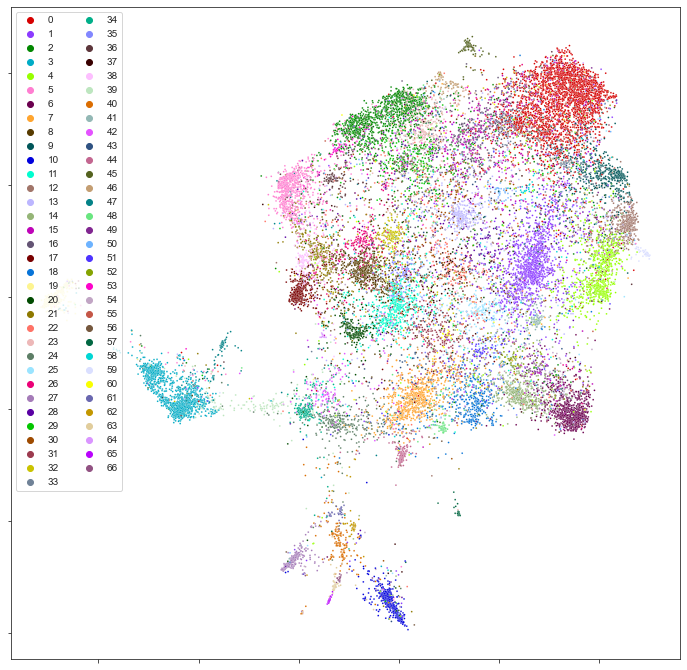

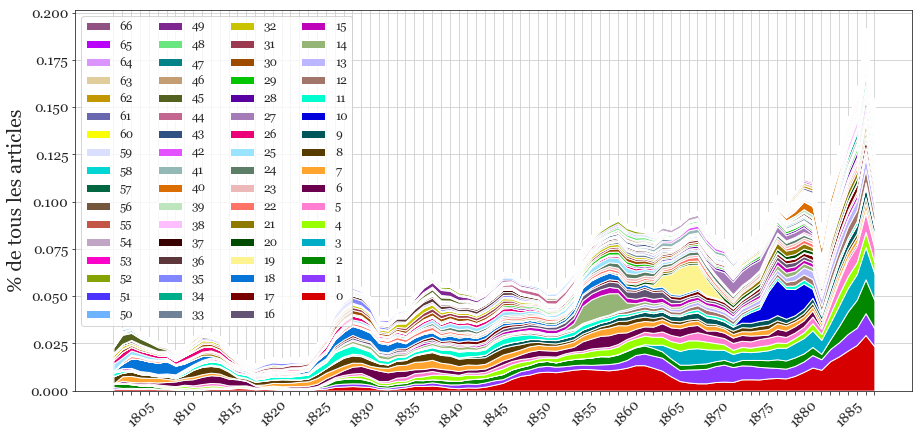

In [60]:
t2v = train_and_plot_top2vec(min_len=2)

In [12]:
t2v = Top2Vec.load('../data/models/top2vec_150522/t2v_model.pkl')

In [13]:
t2v.get_num_topics()

46

Proceeding with 16 topics


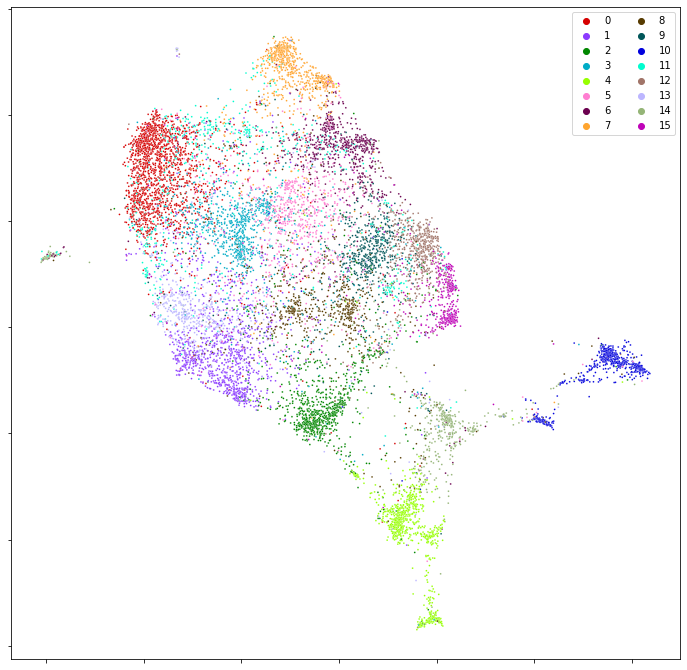






Reduction to 16 topics


---------- Topic 0 from 16 ----------
['stimme' 'herz' 'rief' 'leise' 'liebe' 'augen' 'blick' 'hand' 'geficht'
 'lippen' 'kopf' 'fragte' 'blickte' 'dachte' 'thur' 'seele' 'madchen'
 'arme' 'auge' 'empor' 'gesicht' 'draußen' 'weiß' 'herzen' 'fuhlte' 'wort'
 'gedanken' 'alte' 'kind' 'mutter' 'vater' 'stirn' 'leben' 'ferne'
 'dunkel' 'welt' 'antlitz' 'gott' 'blicke' 'hande' 'mantel' 'fußen'
 'flusterte' 'lacheln' 'wolken' 'lachte' 'klang' 'freund' 'mund' 'schien']

---------- Topic 1 from 16 ----------
['pflanzen' 'klima' 'pflanze' 'bodens' 'boden' 'moglichst' 'warme'
 'anwendung' 'dunger' 'feuchtigkeit' 'oberflache' 'beziehung' 'winter'
 'weise' 'giebt' 'besteht' 'gewohnlich' 'entwickelung' 'bildet' 'liefert'
 'anlage' 'stoffe' 'ausgesetzt' 'erwarmung' 'regel' 'saat' 'erforderlich'
 'verdunstung' 'falle' 'wurzeln' 'tritt' 'vermag' 'geschieht' 'stets'
 'luft' 'futter' 'dungung' 'unkraut' 'gedeihen' 'entsteht' 'acker'
 'besitzen' 'dient' 'warmeleiter' 'thatsac

In [14]:
compare_reduced_topics(t2v, 16)

In [27]:
df_small = map_topics_to_main_df(t2v, df, reduction=16)

In [30]:
for i in range(16):
    print('--------', i, '--------')
    print(df_small.heading2[df_small.main_topic == i].value_counts()[:15])

-------- 0 --------
Vermischtes             37
Riga                    22
Inland                  22
(Fortsetzung.)          18
(Schluß.)               17
Durchgebrannt!          16
Die billige Stadt       14
Berliner Briefe         14
Bilder aus dem Leben    12
Jan Swert               11
Am Vorabend             10
Der junge Straigan      10
Um Liebe und Glück      10
A. Z                     8
Der Kopf der Freya       8
Name: heading2, dtype: int64
-------- 1 --------
Riga                                                  36
Vermischtes                                           34
Inland                                                29
Locales                                               18
Technischer Verein                                    11
Feuilleton                                            10
Mittheilungen                                          7
London                                                 7
Vermischte Nachrichten                                 7
Mannigfaltige

## Early model

In [86]:
early_filter = list(df[(df.year<1860) & (df.readability == 1)].index)
late_filter = list(df[(df.year>=1860) & (df.readability == 1)].index)

In [87]:
len(early_filter) + len(late_filter)

256996

In [89]:
spans_early = build_spans(sents, entities, window=20, stretch=100, min_len=2, index_range = range(len(early_filter)))

0it [00:00, ?it/s]

Building corpus


0it [00:00, ?it/s]

2022-05-15 17:49:29,771 - top2vec - INFO - Pre-processing documents for training


corpus length: 8032
Training...


2022-05-15 17:49:34,231 - top2vec - INFO - Creating joint document/word embedding
2022-05-15 17:51:40,886 - top2vec - INFO - Creating lower dimension embedding of documents
2022-05-15 17:52:01,710 - top2vec - INFO - Finding dense areas of documents
2022-05-15 17:52:02,676 - top2vec - INFO - Finding topics


Found 27 topics


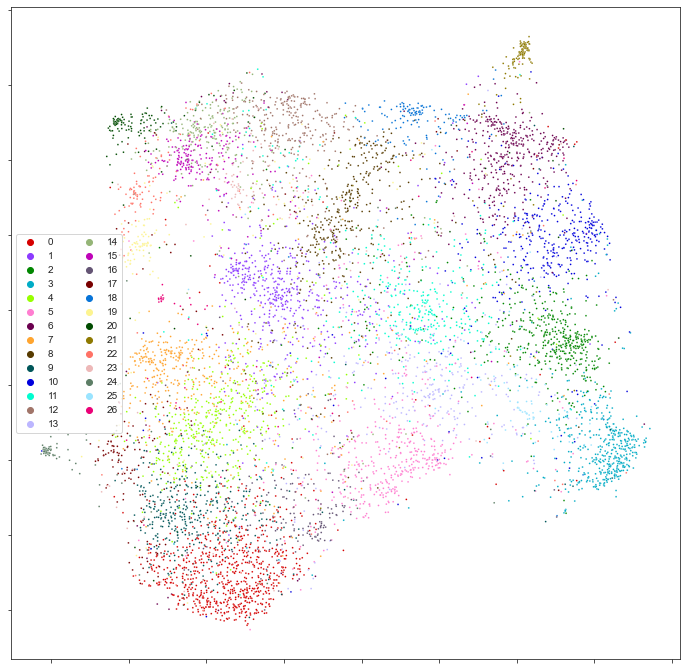

In [111]:
t2v_early = train_and_plot_top2vec(min_len=2, index_range=range(len(early_filter)))

Building corpus


0it [00:00, ?it/s]

2022-05-15 17:52:33,054 - top2vec - INFO - Pre-processing documents for training


corpus length: 5703
Training...


2022-05-15 17:52:39,952 - top2vec - INFO - Creating joint document/word embedding
2022-05-15 17:54:13,979 - top2vec - INFO - Creating lower dimension embedding of documents
2022-05-15 17:54:28,293 - top2vec - INFO - Finding dense areas of documents
2022-05-15 17:54:28,989 - top2vec - INFO - Finding topics


Found 21 topics


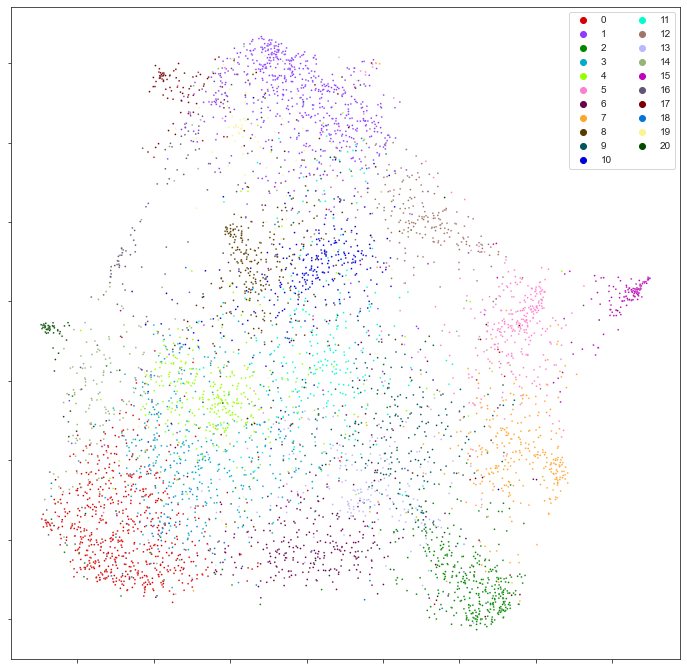

In [112]:
t2v_late = train_and_plot_top2vec(min_len=2, index_range=range(len(late_filter)))

Proceeding with 10 topics


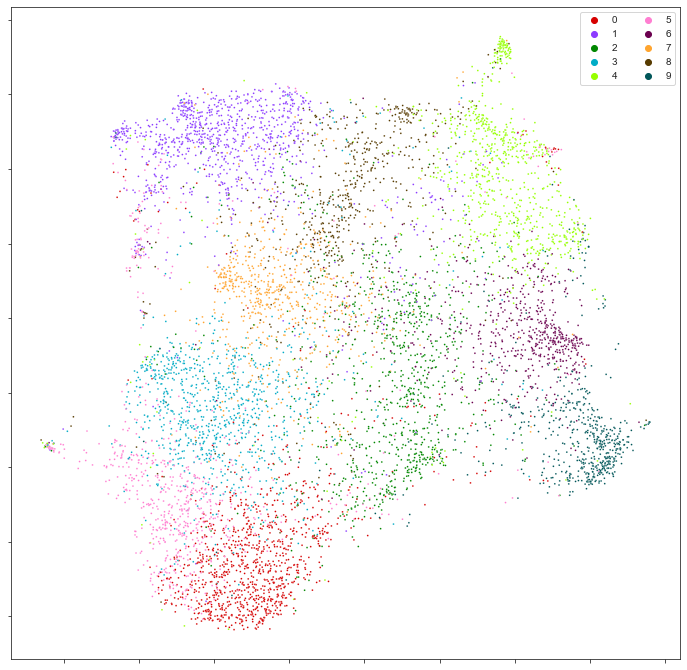






Reduction to 10 topics


---------- Topic 0 from 10 ----------
['rief' 'augen' 'herz' 'stimme' 'mutter' 'fragte' 'lippen' 'seele' 'hand'
 'liebe' 'schrie' 'worte' 'fuhlte' 'wort' 'vater' 'gesicht' 'freunde'
 'lacheln' 'antlitz' 'welt' 'arme' 'blickte' 'lachelnd' 'madchen' 'blicke'
 'dachte' 'kind' 'gefuhl' 'versetzte' 'junge' 'hielt' 'antwortete' 'mund'
 'leise' 'weiß' 'mannes' 'lebens' 'herzen' 'hande' 'druckte' 'selber'
 'gott' 'freund' 'kopf' 'antwort' 'tone' 'brust' 'fußen' 'leben' 'herzens']

---------- Topic 1 from 10 ----------
['schaden' 'hauser' 'dacher' 'beschadigt' 'angerichtet' 'gebaude'
 'zerstort' 'abgedeckt' 'scheunen' 'fortgerissen' 'verwustungen'
 'verwustet' 'wolkenbruch' 'hausern' 'uberschwemmt' 'entwurzelt'
 'menschen' 'heimgesucht' 'vernichtet' 'baume' 'verheerungen' 'trummern'
 'felder' 'ganzlich' 'umgeworfen' 'muhlen' 'brucken' 'uberschwemmte'
 'vieh' 'weggerissen' 'umgegend' 'weggeschwemmt' 'entlud' 'mehreren'
 'anrichtete' 'mehrere' 'hagel' 'erschlagen' 'b

In [117]:
compare_reduced_topics(t2v_early, 10)

Proceeding with 10 topics


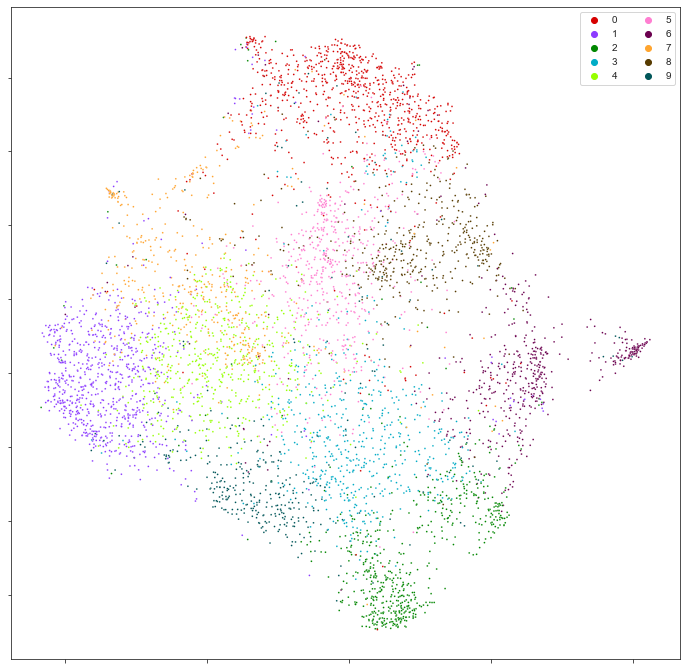






Reduction to 10 topics


---------- Topic 0 from 10 ----------
['hauser' 'zerstort' 'dacher' 'wolkenbruch' 'fortgerissen' 'vernichtet'
 'scheunen' 'verwustet' 'feldern' 'verwustung' 'beschadigt' 'verwustungen'
 'uberschwemmt' 'schaden' 'umgesturzt' 'muhlen' 'zerbrochen' 'brucken'
 'hausern' 'entwurzelt' 'heimgesucht' 'umgegend' 'angerichtet' 'abgedeckt'
 'menschen' 'vieh' 'ortschaften' 'heftiger_sturm' 'ganzlich' 'dorfern'
 'verheert' 'gebaude' 'belauft' 'eingesturzt' 'umgeworfen' 'kirchen'
 'felder' 'orten' 'verheerungen' 'weggerissen' 'wuthete' 'baume'
 'menschenleben' 'entlud' 'weggeschwemmt' 'betroffen' 'einwohner'
 'gebauden' 'dachern' 'anrichtete']

---------- Topic 1 from 10 ----------
['rief' 'hand' 'stimme' 'herz' 'blick' 'lippen' 'wort' 'seele' 'dunkel'
 'blickte' 'blicke' 'liebe' 'augen' 'gesicht' 'antwortete' 'seht' 'horte'
 'worte' 'fragte' 'ewig' 'welt' 'schrie' 'offnete' 'mund' 'thure'
 'vergessen' 'herzen' 'tone' 'mutter' 'fußen' 'draußen' 'stolz' 'gedanken'
 'dach

In [118]:
compare_reduced_topics(t2v_late, 10)